In [1]:

import sys
sys.path.append('../mbt_gym/')

from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.agents.BaselineAgents import RandomAgent, FixedSpreadAgent, AvellanedaStoikovAgent, CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.agents.PolicyGradientAgent import PolicyGradientAgent
from mbt_gym.stochastic_processes.midprice_models import HistoricalMidpriceModel
import os
from hftbacktest.data.utils import tardis
import matplotlib.pyplot as plt
import numpy as np
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord
from utils import *


In [2]:
### Data ###

base_path = os.path.join(os.path.dirname("__file__"))
trades_file = os.path.join(base_path, "data/BTCUSDT_trades.csv.gz")
book_file = os.path.join(base_path, "data/BTCUSDT_book.csv.gz")

maker_fee = 0.0001 # Limit order fee - 0.10% for binance
taker_fee = 0.0001 # Market order fee - 0.10% for binance
entry_lantency = 10_000_000 # 10ms
response_latency = 10_000_000 # 10ms
tick_size = 0.1
lot_size = 0.001 # we should reduce it for BTCUST

data = tardis.convert(
    [trades_file, book_file]
    )

asset = (
    BacktestAsset()
        .data([data])
        .linear_asset(1.0)
        .constant_latency(entry_lantency, response_latency) # 10ms
        .risk_adverse_queue_model()
        .no_partial_fill_exchange()
        .trading_value_fee_model(maker_fee, taker_fee)
        .tick_size(tick_size)
        .lot_size(lot_size)
        .last_trades_capacity(0)
)


Reading data/BTCUSDT_trades.csv.gz
Reading data/BTCUSDT_book.csv.gz
Correcting the latency
Correcting the event order


The `asset` variable is a data structure that contains the order book every 100ms and all the trades.

The `hbt` variable is an object of type `HashMapMarketDepthBacktest` that allows resimulating the evolution of trades within the `asset`.

### Simulation Mechanics

- `hbt.elapse(dt)` advances the simulation by `dt` nanoseconds.
- Orders can be placed using:
  ```python
  hbt.submit_buy_order(asset_no, order_id, price, lot_order_qty, GTX, LIMIT, False)
- The simulation is then advanced again to check if the order has been executed.

### Model Components
We use the following models:

- `constant_latency()`
- `risk_adverse_queue_model()`
- `no_partial_fill_exchange()`
- `trading_value_fee_model()`


### Execution Rules for Limit Orders

#### Bid Limit Order Execution
A bid limit order is executed if one of these three conditions is met:

1. The bid limit order price is higher than the best ask limit order price.
2. The bid limit order price is higher than the best bid, and there is an incoming market sell order.
3. The bid limit order price is equal to the best bid, is at the front of the queue, and there is an incoming market sell order.

#### Ask Limit Order Execution
An ask limit order is executed if one of these three conditions is met:

1. The ask limit order price is lower than the best bid limit order price.
2. The ask limit order price is lower than the best ask, and there is an incoming market buy order.
3. The ask limit order price is equal to the best ask, is at the front of the queue, and there is an incoming market buy order.


### Execution Model Assumptions
- With `no_partial_fill_exchange()`, an order is fully executed or not executed at all. (For small trading quantities, this model is realistic.)
- The `risk_adverse_queue_model()` provides a conservative queue position model, where your order’s position in the queue advances only when trades occur at the same price level.


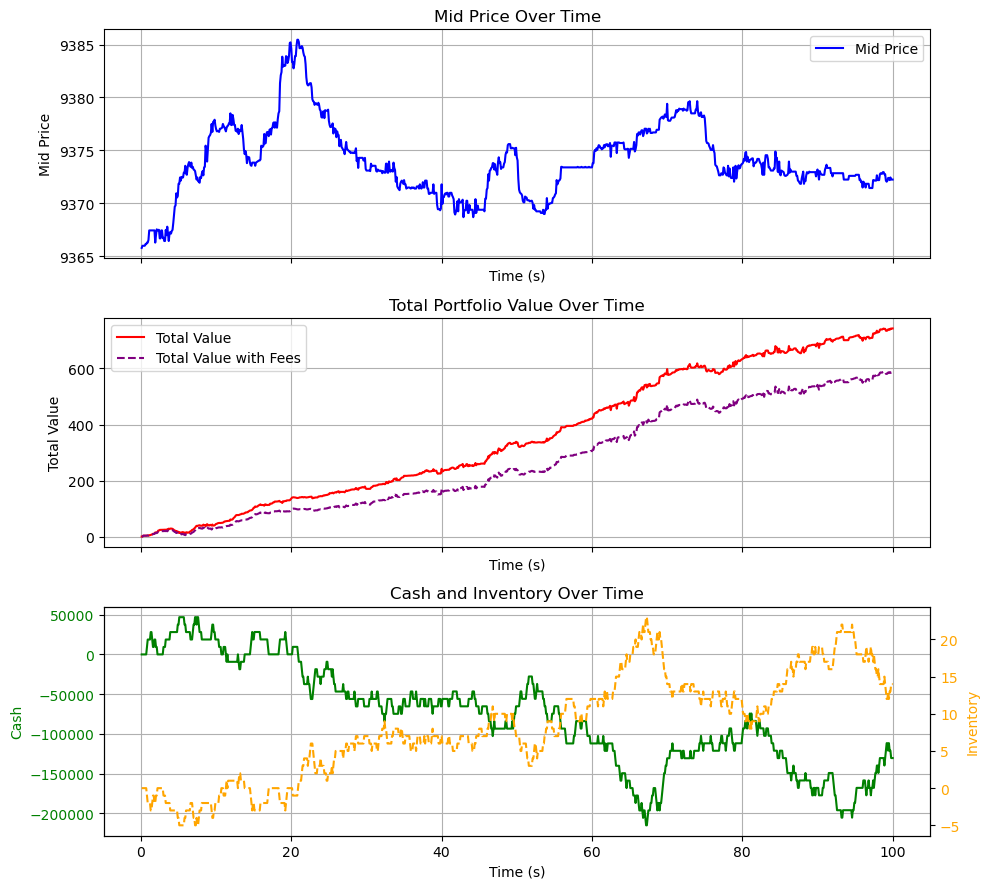

In [3]:

from mbt_gym.gym.TradingEnvironment import BackTestingTradingEnvironment
from mbt_gym.gym.ModelDynamics import BackTestingLimitOrderModelDynamics

# Hyperparameters
terminal_time = 100 # in seconds
step_size = 0.1
n_steps = int(terminal_time / step_size)
seed = 42
order_qty = 10 # in lot_size
np.random.seed(seed)

# Arrival and fill models parameters
intensity = np.array([140, 140])
fill_exponent = 1.5

n_prices = int(terminal_time/step_size)
hbt = HashMapMarketDepthBacktest([asset])
historical_prices = get_midprices(hbt, dt=step_size, size=n_prices)
hbt.close()

midprice_model = HistoricalMidpriceModel(midprice_list=historical_prices, step_size=step_size, seed=seed)
arrival_model = PoissonArrivalModel(intensity=intensity, step_size=step_size, seed=seed)
fill_probability_model = ExponentialFillFunction(fill_exponent, step_size=step_size, seed=seed)
model_dynamics = BackTestingLimitOrderModelDynamics(midprice_model=midprice_model, arrival_model=arrival_model, fill_probability_model=fill_probability_model)

env = BackTestingTradingEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=seed, model_dynamics=model_dynamics)
agent = RandomAgent(env, seed=seed)



#@njit
# This function back test agent for LimitOrderModelDynamics (only limit orders)
def agent_back_testing(hbt, env, agent, step_size, order_qty, recorder):
    """
    """

    ask_executed, bid_executed, asset_no = 0, 0, 0
    tick_size = hbt.depth(asset_no).tick_size
    lot_size = hbt.depth(asset_no).lot_size
    obs, real_obs = env.reset()

    hbt.elapse(1_000_000_000 * 2) # Skip the two first second

    # Placing orders
    action = agent.get_action(obs)
    order_qty = 1000 # the current mbt-gym env only allow to buy 1 qty of the asset (1000 correspond to 1/lot_size)
    bid_order_id, ask_order_id = place_orders(hbt, action, asset_no, lot_size, tick_size, order_qty)

    while hbt.elapse(1_000_000_000 * step_size) == 0:

        hbt.clear_inactive_orders(asset_no)

        # get the executed status of the previous orders
        bid_executed, ask_executed = get_executed_status(hbt, bid_order_id, ask_order_id, asset_no)

        obs, real_obs, _, done, _ = env.step(action, np.array([[bid_executed, ask_executed]]))
        
        recorder.record(real_obs, hbt)

        if (env.num_trajectories > 1 and done[0]) or (env.num_trajectories == 1 and done):
            break
        
        # Placing new orders
        action = agent.get_action(obs)
        bid_order_id, ask_order_id = place_orders(hbt, action, asset_no, lot_size, tick_size, order_qty)

    return True


recorder = Recorder(step_size, n_steps, order_qty)

hbt = HashMapMarketDepthBacktest([asset])

agent_back_testing(hbt, env, agent, step_size, order_qty, recorder)

_ = hbt.close()

recorder.plot()


